In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
from keras.backend import clear_session
from tensorflow.keras.optimizers import Adam, SGD
from pathlib import Path
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential, Model, load_model
from keras import initializers, regularizers
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, History
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import os
import matplotlib.image as mpimg
from time import time
from sklearn.model_selection import train_test_split
import tensorflow as tf
# from PIL import image

Using TensorFlow backend.


In [2]:
train_safe= (len([iq for iq in os.scandir('data/training/safe')]))
train_sexy= (len([iq for iq in os.scandir('data/training/sexy')]))
train_nude= (len([iq for iq in os.scandir('data/training/nude')]))
test_safe= (len([iq for iq in os.scandir('data/testing/safe')]))
test_sexy= (len([iq for iq in os.scandir('data/testing/sexy')]))
test_nude= (len([iq for iq in os.scandir('data/testing/nude')]))

In [3]:
train_data = [train_safe, train_sexy, train_nude]
test_data = [test_safe, test_sexy, test_nude]

In [4]:
print("Number of train data is: ", sum(train_data))
print("Number of test data is: ", sum(test_data))


Number of train data is:  85946
Number of test data is:  9447


In [5]:
train_path = r"data/training"
test_path = r"data/testing"

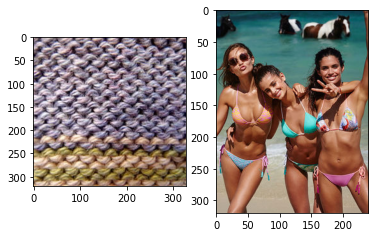

In [6]:

f, (ax1, ax2) = plt.subplots(1, 2)
img=mpimg.imread(train_path + "/safe/5kiu38012-4V0cGAk.jpg.jpeg")
ax1.imshow(img)
img=mpimg.imread(test_path + "/sexy/0EC08508-3F44-4607-B4A2-CD8EE1558235.jpg")
ax2.imshow(img)

In [7]:
train_data_generation = ImageDataGenerator(
    rescale = 1./255,# pixel from range[0,255])
    rotation_range= 30,      
    horizontal_flip = True,
    height_shift_range= 0.2,
    width_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    channel_shift_range=20
)
validation_data_generation = ImageDataGenerator(
    rescale = 1./255
)

In [8]:
size = 224
train_generator = train_data_generation.flow_from_directory(
    train_path,
    target_size=(size, size),
    class_mode='categorical',
    batch_size= 64
    )
validation_generator = validation_data_generation.flow_from_directory(
    test_path,
    target_size=(size, size),
    class_mode='categorical',
    batch_size= 64
    )

Found 85946 images belonging to 3 classes.
Found 9447 images belonging to 3 classes.


In [9]:

conv_m = MobileNetV2(
    weights='imagenet',include_top=False, input_shape= (size, size, 3))
conv_m.trainable = False #Dong bang model
conv_m.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [10]:
from tensorflow.keras import layers
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
model = Sequential()
model.add(conv_m)
model.add(AveragePooling2D(pool_size=(7, 7))) #average [7,7] => []
model.add(Flatten())
model.add(Dense(32, activation= 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3, activation= 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 1, 1280)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                40992     
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 9

In [11]:
filepath = "bestweight.h5"
checkpoint = ModelCheckpoint("weights{epoch:02d}.h5", 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')
lr_reduce = ReduceLROnPlateau(monitor='val_loss', 
                              factor=np.sqrt(0.1), 
                              patience=5, 
                              verbose=1, 
                              cooldown=0, 
                              min_lr=0.5e-6)
callbacks = [checkpoint, lr_reduce]

In [12]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import categorical_crossentropy
model.compile(
loss='categorical_crossentropy',
optimizer=SGD(lr = 0.1, momentum = 0.1),  
metrics=['accuracy']
)

In [13]:
history = model.fit(
    train_generator,
    callbacks=callbacks,
    epochs=100,
    steps_per_epoch=10,
    validation_data= validation_generator,
    validation_steps=10,
    initial_epoch = 1
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 10 steps, validate for 10 steps
Epoch 2/100
10/10 [==============================] - 12s 1s/step - loss: 1.2073 - accuracy: 0.5437 - val_loss: 0.9432 - val_accuracy: 0.5516
Epoch 3/100
10/10 [==============================] - 9s 853ms/step - loss: 0.7917 - accuracy: 0.6766 - val_loss: 1.5021 - val_accuracy: 0.3781
Epoch 4/100
10/10 [==============================] - 8s 834ms/step - loss: 0.6786 - accuracy: 0.7359 - val_loss: 1.7309 - val_accuracy: 0.3625
Epoch 5/100
10/10 [==============================] - 8s 833ms/step - loss: 0.7333 - accuracy: 0.7141 - val_loss: 1.5561 - val_accuracy: 0.4172
Epoch 6/100
10/10 [==============================] - 8s 837ms/step - loss: 0.7071 - accuracy: 0.6922 - val_loss: 1.8139 - val_accuracy: 0.4078
Epoch 7/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.6623 - accuracy: 0.7309
Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.031622777072899885.
10/10 [==============

UnknownError: 2 root error(s) found.
  (0) Unknown:  OSError: image file is truncated
Traceback (most recent call last):

  File "C:\Users\Admin\anaconda3\envs\condaenv\lib\site-packages\PIL\ImageFile.py", line 235, in load
    s = read(self.decodermaxblock)

  File "C:\Users\Admin\anaconda3\envs\condaenv\lib\site-packages\PIL\PngImagePlugin.py", line 896, in load_read
    cid, pos, length = self.png.read()

  File "C:\Users\Admin\anaconda3\envs\condaenv\lib\site-packages\PIL\PngImagePlugin.py", line 162, in read
    length = i32(s)

  File "C:\Users\Admin\anaconda3\envs\condaenv\lib\site-packages\PIL\_binary.py", line 85, in i32be
    return unpack_from(">I", c, o)[0]

struct.error: unpack_from requires a buffer of at least 4 bytes


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "C:\Users\Admin\anaconda3\envs\condaenv\lib\site-packages\tensorflow_core\python\ops\script_ops.py", line 236, in __call__
    ret = func(*args)

  File "C:\Users\Admin\anaconda3\envs\condaenv\lib\site-packages\tensorflow_core\python\data\ops\dataset_ops.py", line 789, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "C:\Users\Admin\anaconda3\envs\condaenv\lib\site-packages\tensorflow_core\python\keras\engine\data_adapter.py", line 975, in generator_fn
    yield x[i]

  File "C:\Users\Admin\anaconda3\envs\condaenv\lib\site-packages\keras_preprocessing\image\iterator.py", line 65, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "C:\Users\Admin\anaconda3\envs\condaenv\lib\site-packages\keras_preprocessing\image\iterator.py", line 230, in _get_batches_of_transformed_samples
    interpolation=self.interpolation)

  File "C:\Users\Admin\anaconda3\envs\condaenv\lib\site-packages\keras_preprocessing\image\utils.py", line 138, in load_img
    img = img.resize(width_height_tuple, resample)

  File "C:\Users\Admin\anaconda3\envs\condaenv\lib\site-packages\PIL\Image.py", line 1961, in resize
    self.load()

  File "C:\Users\Admin\anaconda3\envs\condaenv\lib\site-packages\PIL\ImageFile.py", line 241, in load
    raise OSError("image file is truncated") from e

OSError: image file is truncated


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[loss/dense_1_loss/softmax_cross_entropy_with_logits/Shape_2/_8]]
  (1) Unknown:  OSError: image file is truncated
Traceback (most recent call last):

  File "C:\Users\Admin\anaconda3\envs\condaenv\lib\site-packages\PIL\ImageFile.py", line 235, in load
    s = read(self.decodermaxblock)

  File "C:\Users\Admin\anaconda3\envs\condaenv\lib\site-packages\PIL\PngImagePlugin.py", line 896, in load_read
    cid, pos, length = self.png.read()

  File "C:\Users\Admin\anaconda3\envs\condaenv\lib\site-packages\PIL\PngImagePlugin.py", line 162, in read
    length = i32(s)

  File "C:\Users\Admin\anaconda3\envs\condaenv\lib\site-packages\PIL\_binary.py", line 85, in i32be
    return unpack_from(">I", c, o)[0]

struct.error: unpack_from requires a buffer of at least 4 bytes


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "C:\Users\Admin\anaconda3\envs\condaenv\lib\site-packages\tensorflow_core\python\ops\script_ops.py", line 236, in __call__
    ret = func(*args)

  File "C:\Users\Admin\anaconda3\envs\condaenv\lib\site-packages\tensorflow_core\python\data\ops\dataset_ops.py", line 789, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "C:\Users\Admin\anaconda3\envs\condaenv\lib\site-packages\tensorflow_core\python\keras\engine\data_adapter.py", line 975, in generator_fn
    yield x[i]

  File "C:\Users\Admin\anaconda3\envs\condaenv\lib\site-packages\keras_preprocessing\image\iterator.py", line 65, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "C:\Users\Admin\anaconda3\envs\condaenv\lib\site-packages\keras_preprocessing\image\iterator.py", line 230, in _get_batches_of_transformed_samples
    interpolation=self.interpolation)

  File "C:\Users\Admin\anaconda3\envs\condaenv\lib\site-packages\keras_preprocessing\image\utils.py", line 138, in load_img
    img = img.resize(width_height_tuple, resample)

  File "C:\Users\Admin\anaconda3\envs\condaenv\lib\site-packages\PIL\Image.py", line 1961, in resize
    self.load()

  File "C:\Users\Admin\anaconda3\envs\condaenv\lib\site-packages\PIL\ImageFile.py", line 241, in load
    raise OSError("image file is truncated") from e

OSError: image file is truncated


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_distributed_function_13721]

Function call stack:
distributed_function -> distributed_function


In [14]:
history = model.fit_generator(
    train_generator,
    callbacks=callbacks,
    epochs=100,
    steps_per_epoch=10,
    validation_data=validation_generator,
    validation_steps=10,
    initial_epoch = 11
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 10 steps, validate for 10 steps
Epoch 12/100
10/10 [==============================] - 8s 815ms/step - loss: 0.6135 - accuracy: 0.7547 - val_loss: 1.5175 - val_accuracy: 0.4141
Epoch 13/100
10/10 [==============================] - 8s 845ms/step - loss: 0.6544 - accuracy: 0.7359 - val_loss: 1.5125 - val_accuracy: 0.4187
Epoch 14/100
10/10 [==============================] - 8s 820ms/step - loss: 0.6286 - accuracy: 0.7516 - val_loss: 1.4135 - val_accuracy: 0.4328
Epoch 15/100
10/10 [==============================] - 8s 831ms/step - loss: 0.6171 - accuracy: 0.7344 - val_loss: 1.4433 - val_accuracy: 0.4297
Epoch 16/100
10/10 [==============================] - 8s 773ms/step - loss: 0.5951 - accuracy: 0.7641 - val_loss: 1.4526 - val_accuracy: 0.4313
Epoch 17/100
10/10 [==============================] - 8s 806ms/step - loss: 0.6038 - accuracy: 0.7750 - val_loss

KeyboardInterrupt: 

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model.save('best_weight.h5')